In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.eda import BCW_Explorer
from sklearn import preprocessing

sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
eda = BCW_Explorer()

# 1. Data Quality

In [3]:
eda.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
(mean, radius)                      569 non-null float64
(mean, texture)                     569 non-null float64
(mean, perimeter)                   569 non-null float64
(mean, area)                        569 non-null float64
(mean, smoothness)                  569 non-null float64
(mean, compactness)                 569 non-null float64
(mean, concavity_intensity)         569 non-null float64
(mean, concavity_count)             569 non-null float64
(mean, symmetry)                    569 non-null float64
(mean, fractal_dimension)           569 non-null float64
(std, radius)                       569 non-null float64
(std, texture)                      569 non-null float64
(std, perimeter)                    569 non-null float64
(std, area)                         569 non-null float64
(std, smoothness)                   569 non-null float64
(std, compactness)                  569 

# 2. Data Analysis

## 2.1 Overview of Variables

In [4]:
print(
    'Attributes:\n\t{0}\n'.format(
        ', '.join(str(x) for x in eda.data.columns.get_level_values('attributes').unique() if x)
    ),
    '\n... where each attribute is summarized by:\n\t{0}'.format(
        ', '.join(str(x) for x in eda.data.columns.get_level_values('summaries').unique() if x != 'label')
    ),
    '\n\n... for a total of 30 features'
)


Attributes:
	radius, texture, perimeter, area, smoothness, compactness, concavity_intensity, concavity_count, symmetry, fractal_dimension
 
... where each attribute is summarized by:
	mean, std, mean_max3 

... for a total of 30 features


---
At first, we should assume that there is correlation between some of the features given the nature of the attributes which they summarize.
* radius yields (although the attribute is the mean of distances from center to points on the perimeter)
    * perimiter, area, smoothness (local variation in radius lengths) and compactness (perimeter^2 / area - 1.0);

We explore whether they significantly correlate in the section 2.3
<br />

\> **What is the attribute Fractal Dimension?**<br />
&emsp;Fractal dimension is a measure of how regular the contour of a shape is.<br />
It is approximated by measuring the downward slope of the log of observed perimeter plotted agains the log of a "ruler" size.<br />
Hence, a higher value corresponds to a less regular contour, which in turn means a higher probability of malignancy (Wolberg et al. 1994)


## 2.2 Research Questions (RQs)

1. What are the most significant features, and how to measure significance?
2. Which classifiers are most suitable for the task, and how to decide?
3. How much better (or worse) are classifiers induced from reduced dimensionality?
4. What performance measure should be favored during hyperparameter tuning?

## 2.3 Class Imbalance, Feature Distribution and Selection

In [5]:
def plot_compare_classdistribution(in_df: pd.DataFrame, summary='mean', ax=None):
    # scales the data
    df = in_df.apply(preprocessing.scale, axis=0).copy()
    # df['label'] = df['label'].map({1: 'Malignant', 0: 'Benign'})

    # melts columns' (name, value) pair into two columns
    df =\
        pd.melt(
            pd.concat(
                [
                    df['label'],
                    df.xs(summary, level='summaries', axis=1)
                ],
                axis=1
            ),
            id_vars='label',
            var_name='features',
            value_name='value'
        )

    # plots comparative distribution of classes for each 'mean' feature
    return\
        sns.violinplot(
            ax=ax,
            data=df,
            y="value",
            x="features",
            hue="label",
            inner="quartile",
            split=True,
        )

from scipy.stats import boxcox, skew


def transform_skew(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Transforms data with Boxcox transformation
    Keeps the transformation only if it is less skewed than the original
    '''
    skew_transformed = pd.DataFrame()

    for feat in df.drop('label', axis=1):

        data = df.drop('label', axis=1)[feat].values
        posdata = data[data > 0]
        # posdata = eda.data[eda.data[feat]>0][feat]

        x, lmbda = boxcox(posdata, lmbda=None)
        
        transform = np.empty_like(data)
        transform[data > 0] = x
        transform[data == 0] = -1/lmbda

        if abs(skew(transform)) < abs(skew(data)):
            skew_transformed[feat] = transform

        else:
            skew_transformed[feat] = data
    
    skew_transformed.columns =\
        pd.MultiIndex.from_tuples(
            list(skew_transformed.columns),
            names=('summaries', 'attributes')
        )

    return skew_transformed

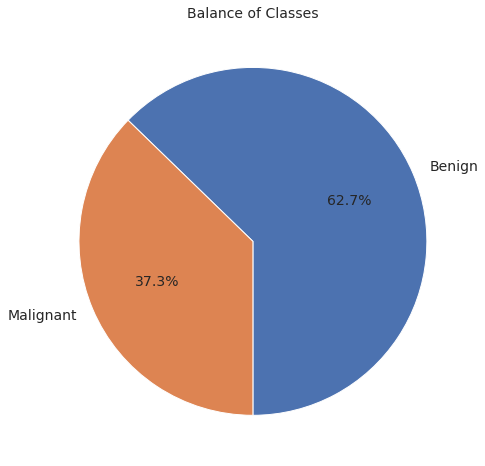

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title('Balance of Classes', fontsize=14)

eda.data['label']\
    .map({1: 'Malignant', 0: 'Benign'})\
    .value_counts()\
    .plot(
        ax=ax,
        kind='pie',
        autopct='%1.1f%%',
        startangle=270,
        fontsize=14,
        label=''
    )

plt.show()

### - Imbalanced Classes
&emsp;There are almost twice as many benign observations than malignant, which can become an issue while inducing machine learning models. Thus, we must employ a sampling technique.<br />
<br />

<center><img style="margin-bottom:5mm" src="https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png"><center/>
<center>Figure 1. Approaches to resampling<center/>
<center style="margin-bottom:5mm">Source. https://tinyurl.com/yy2qtbe2<center/>

<p>&emsp;However, before applying any resampling method to our data, we must ensure that it meets some assumptions that sampling methods require; thus, we investigate the distribution of our features and whether there are any redundant candidates for removal. From both tasks, the former is comprised of statistical analysis and data visualization, while the latter of feature selection techniques (e.g. correlation analysis and recursive feature elimination (RFE))<p/>

### - Feature Distribution

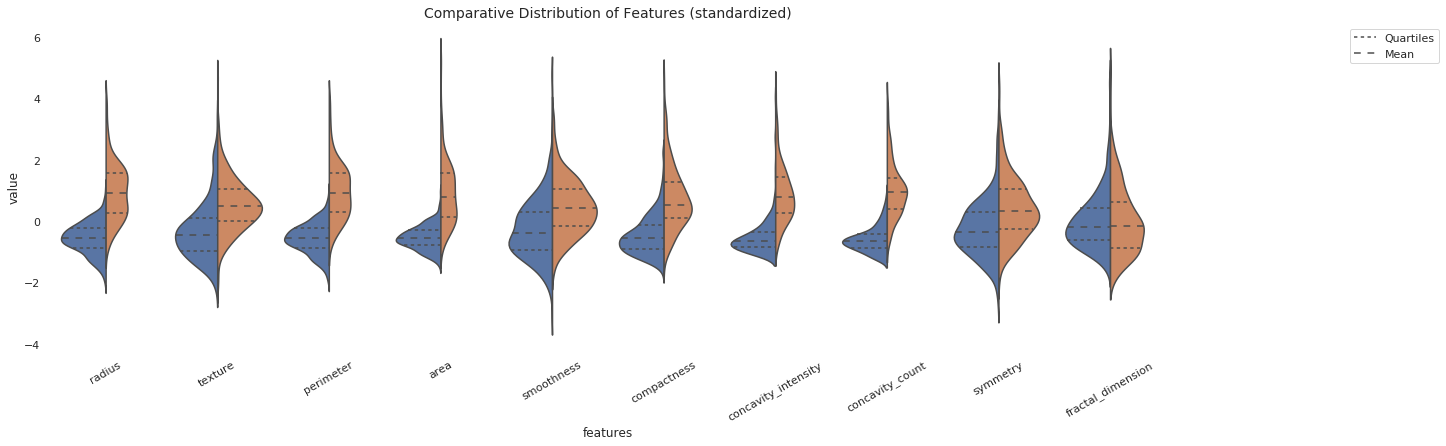

In [7]:
# -------------------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.set_title('Comparative Distribution of Features (standardized)', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plot_compare_classdistribution(eda.data, ax=ax, summary='mean')

ax.tick_params(axis='x', labelrotation=30)
ax.legend_.remove()
leg = ax.legend(['Quartiles', 'Mean'], loc='upper right', bbox_to_anchor=(1.25, 1))

plt.show()

In [8]:
print('Skewness of features:')
eda.data.skew().sort_values(ascending=False).sort_index(level='summaries', sort_remaining=False)

Skewness of features:


summaries  attributes         
mean       area                   1.645732
           concavity_intensity    1.401180
           fractal_dimension      1.304489
           compactness            1.190123
           concavity_count        1.171180
           perimeter              0.990650
           radius                 0.942380
           symmetry               0.725609
           texture                0.650450
           smoothness             0.456324
std        area                   5.447186
           concavity_intensity    5.110463
           fractal_dimension      3.923969
           perimeter              3.443615
           radius                 3.088612
           smoothness             2.314450
           symmetry               2.195133
           compactness            1.902221
           texture                1.646444
           concavity_count        1.444678
mean_max3  area                   1.859373
           fractal_dimension      1.662579
           compactness 

In [9]:
# applies boxcox transformation and decides whether to use it against the original variable
transformed = transform_skew(eda.data)
transformed['label'] = eda.data['label']

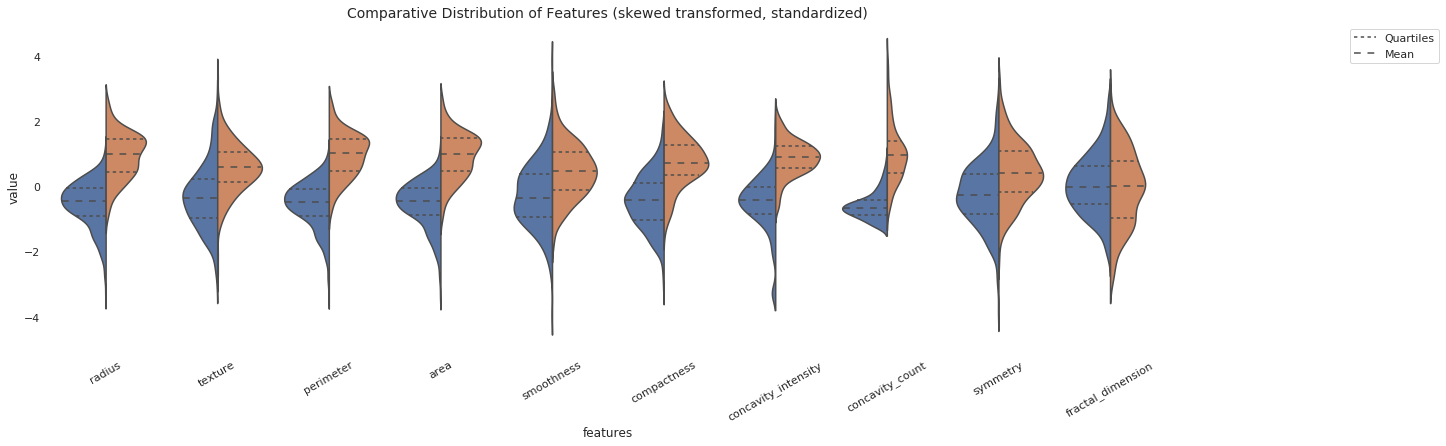

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.set_title('Comparative Distribution of Features (skewed transformed, standardized)', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plot_compare_classdistribution(transformed)

ax.tick_params(axis='x', labelrotation=30)
ax.legend_.remove()
ax.legend(['Quartiles', 'Mean'], loc='upper right', bbox_to_anchor=(1.25, 1))

plt.show()

In [11]:
print('Skewness after Boxcox transform:')
transformed.skew().sort_values(ascending=False).sort_index(level='summaries', sort_remaining=False)

Skewness after Boxcox transform:


summaries  attributes         
mean       concavity_count        1.171180
           fractal_dimension      0.013525
           perimeter              0.006916
           radius                 0.006255
           area                   0.005090
           smoothness             0.002393
           texture               -0.000115
           compactness           -0.001664
           symmetry              -0.007120
           concavity_intensity   -0.654761
mean_max3  concavity_count        0.492616
           perimeter              0.030437
           radius                 0.029596
           area                   0.026589
           fractal_dimension      0.024883
           smoothness             0.001099
           texture               -0.005091
           compactness           -0.005668
           symmetry              -0.031618
           concavity_intensity   -0.371431
std        concavity_count        1.444678
           area                   0.058529
           perimeter   

### - Correlation Analysis

In [12]:
def get_unique_correlation(data: pd.DataFrame, threshold=0.5) -> pd.DataFrame:
    try:
        tmp = data.drop('label', axis=1).copy()
    
    except KeyError:
        pass

    tmp.columns = tmp.columns.to_flat_index()
    dataCorr = tmp.corr(method='pearson')

    dataCorr = dataCorr.mask(np.tril(np.ones(dataCorr.shape)).astype(np.bool))
    dataCorr = dataCorr[abs(dataCorr) >= threshold].stack()

    dataCorr = dataCorr.reset_index(level=0)
    dataCorr.index = pd.MultiIndex.from_tuples(dataCorr.index, names=('summaries', 'attributes'))
    
    return dataCorr.sort_index(level='attributes').sort_index(level='summaries', sort_remaining=False)

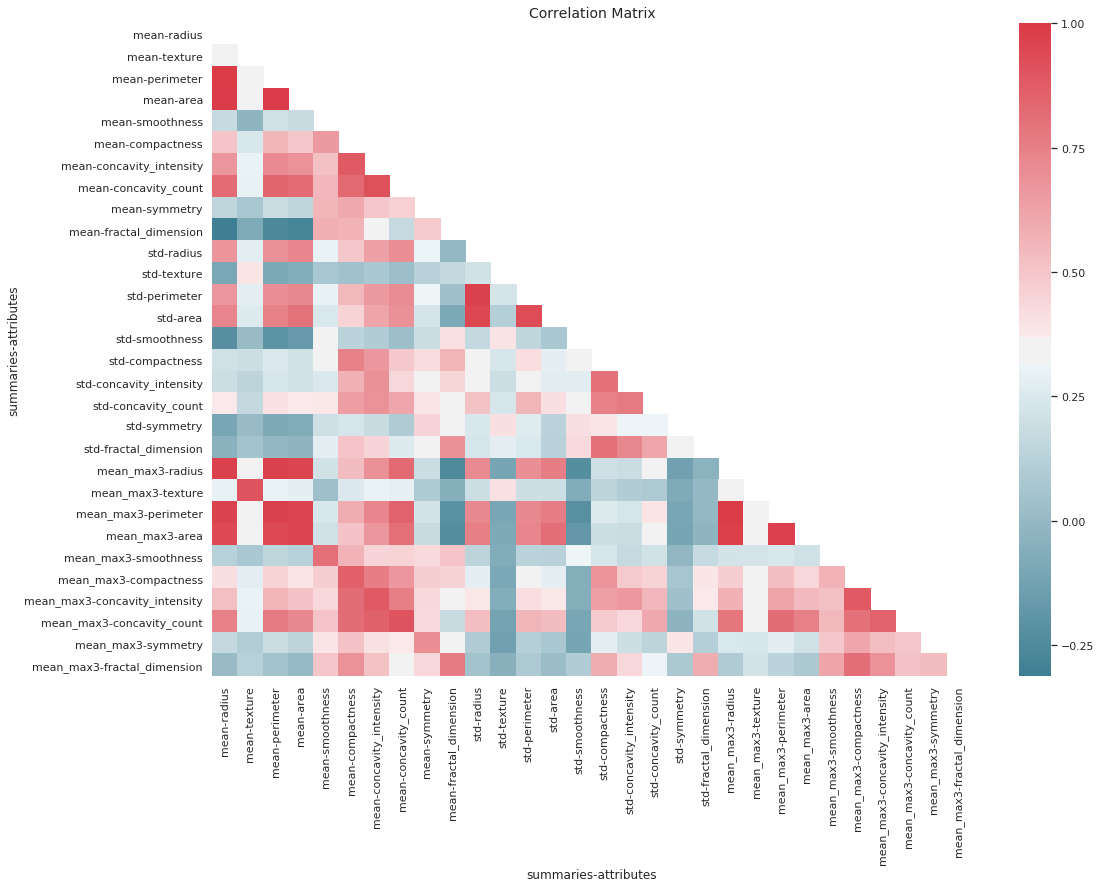

In [13]:
# -------------------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(17, 12))
ax.set_title('Correlation Matrix', fontsize=14)

corr = eda.data.drop('label', axis=1).corr()

# generates an upper diagonal mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(
    corr,
    ax=ax,
    vmax=1,
    cmap=cmap,
    mask=mask,
    annot=False,
    square=False,
)

plt.show()

**Feature Selection Stategy**<br />
&emsp;Before applying an automated search for the optimal dimensionality for each classifer, we investigate features we consider relevant for the sake of comparison. There are a few features (variables) that correlate with many others, which could lead to using them to represent all others. We must how these "subfeatures" correlated to one another. At the end of this process, we will be able to answer RQ1.
* RQ1 - What are the most significant features, and how to measure significance?

In [14]:
# # selects features that have highest number of correlations above the given threshold
# above_threshold = corr.apply(lambda x: x > .9).sum()
# most_correlations = corr[above_threshold.apply(lambda x: x == above_threshold.max())]
# most_correlations[most_correlations.apply(lambda x: x > 0.9)].dropna(axis=1)

**Correlation clustering** is the task of ...

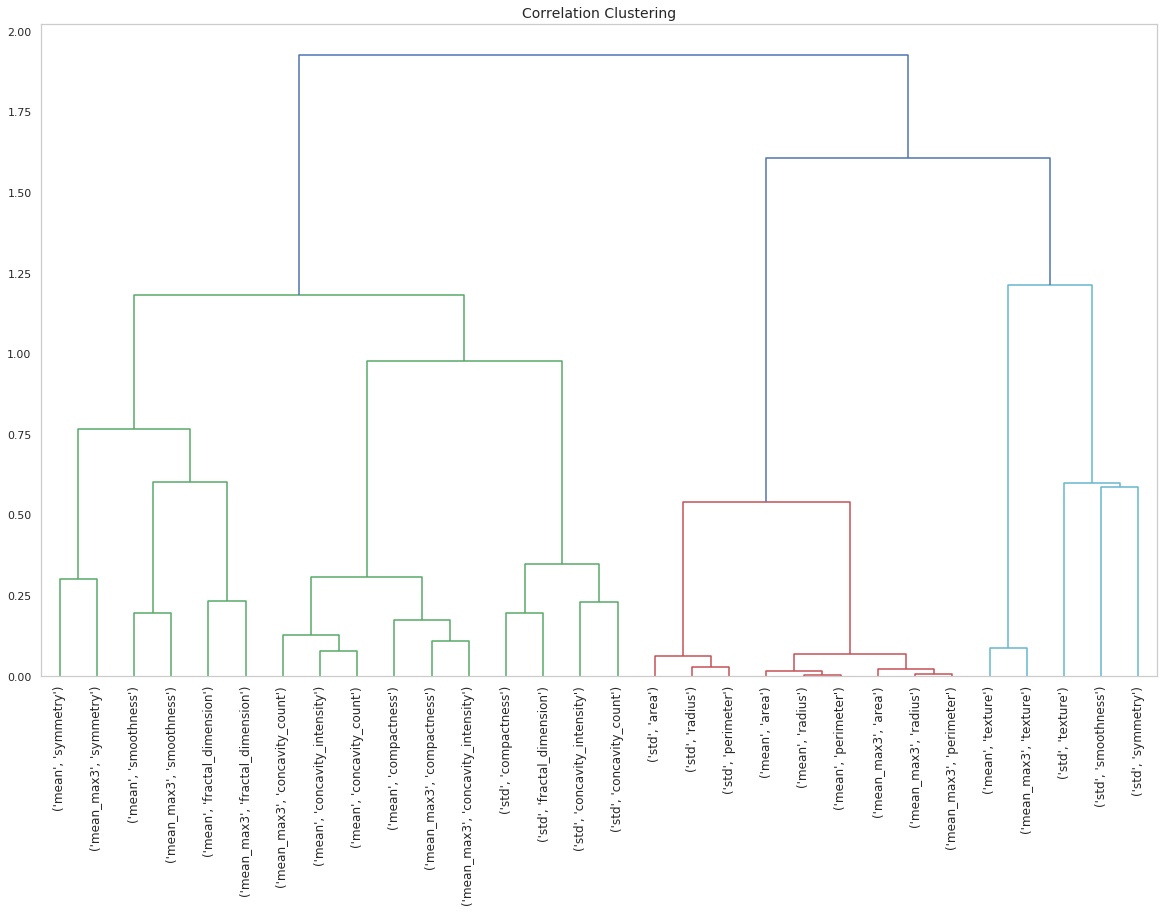

In [69]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# X = get_unique_correlation(eda.data)

def correlation_clustering(corr: np.ndarray, labels: np.ndarray, threshold=0.5, ax=matplotlib.axes._subplots) -> (dict, np.ndarray):
    '''
    '''
    dissimilarity = 1 - np.abs(corr)
    hierarchy = linkage(squareform(dissimilarity), method='ward', metric='distance')
    
    return\
        dendrogram(
            hierarchy, color_threshold=None,
            labels=labels, ax=ax,
            distance_sort='ascending',
            leaf_font_size=12,
            orientation='top',
            # truncate_mode='lastp'
        ),\
        fcluster(hierarchy, threshold, criterion='distance')


fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.set_title('Correlation Clustering', fontsize=14)

d, labels = correlation_clustering(corr.values, corr.index.values, ax=ax)

plt.xticks(rotation=90)
plt.show()


In [16]:
# pd.Series(labels, corr.index.values, name='Feature Cluster').sort_values()

In [125]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig =\
    make_subplots(
        rows=1, cols=2,
        specs=[
            [{'is_3d': True}, {'is_3d': True}]
        ],
        print_grid=False
    )

data =\
    eda.data\
    .loc[:,[('mean', 'texture'), ('mean_max3', 'area'), ('mean_max3', 'smoothness'), ('label', '')]]\
    .droplevel(0, axis=1).rename(columns={'': 'label'})

fig.add_trace(
    go.Scatter3d(
        x=data['texture'],
        y=data['area'],
        z=data['smoothness'],
        mode='markers',
        showlegend=False,
        marker=dict(
            size=12,
            color=data['label'],
            colorscale=['#CC8963', '#5875A4'],
            opacity=1.0
        )
    ),
    row=1, col=1
)


data =\
    transformed\
    .loc[:,[('mean', 'texture'), ('mean_max3', 'area'), ('mean_max3', 'smoothness'), ('label', '')]]\
    .droplevel(0, axis=1).rename(columns={'': 'label'})

fig.add_trace(
    go.Scatter3d(
        x=data['texture'],
        y=data['area'],
        z=data['smoothness'],
        mode='markers',
        showlegend=False,
        marker=dict(
            size=12,
            color=data['label'],
            colorscale=['#CC8963', '#5875A4'],
            opacity=1.0
        )
    ),
    row=1, col=2
)

fig.update_layout(
    width=1200,
    margin=dict(r=10, l=10, b=10, t=10),
    scene = dict(
        xaxis_title='Mean Texture',
        yaxis_title='Worst Area',
        zaxis_title='Worst Smoothness'
    )
)

fig.show()


In [110]:
data['label']

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: label, Length: 569, dtype: Int8